In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, MaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [3]:
# to access data on Google Drive from colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation


In [12]:
size_vect = 768

def label_to_one_hot(label):
  one_hot = [0, 0, 0]
  one_hot[label] = 1
  return one_hot

def prepare_data_bert(data):
  
  data["sentence_embedding"] = data["sentence_embedding"].apply(lambda x : np.asarray([float(value) for value in x[1:-1].split(",")]).astype(np.float32))

  x_train, x_test, _, y_test = train_test_split(data[['id','sentence_embedding']], data['label'], test_size=0.3, random_state=42)

  x_train_to_return = np.zeros(shape=(len(x_train), 768))
  for i in range(len(x_train)):
      x_train_to_return[i] = x_train["sentence_embedding"].values[i]

  x_test_to_return = np.zeros(shape=(len(x_test), 768))
  for i in range(len(x_test)):
      x_test_to_return[i] = x_test["sentence_embedding"].values[i]

  data["yhot"] = data["label"].apply(label_to_one_hot)
  y_train = np.zeros(shape=(len(data), 3))
  for i in range(len(data)):
      y_train[i] = data["yhot"].values[i]
  y_train = y_train.astype(int)

  return x_train_to_return, x_test_to_return, y_train, y_test


# Models

## CNN


In [5]:
def cnn_1(size_vector=768, metric='accuracy'):
  filter_sizes = [5,50,3]
  num_filters = 10
  drop = 0.9
  batch_size = 15
  epochs = 2

  inputs = Input(shape=(size_vector,1), dtype='float32')
  conv = Conv1D(num_filters, kernel_size=filter_sizes[0], padding='valid', kernel_initializer='normal', activation='relu')(inputs)
  maxpool = MaxPool1D(pool_size=2, padding='same')(conv)
  flatten = Flatten()(maxpool)
  dropout = Dropout(drop)(flatten)
  # dense = Dense(units=294912, activation='softmax')(dropout)
  output = Dense(units=3, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])
  return model

def cnn_2(size_vector=768, metric='accuracy'):
  filter_sizes = [5,50,3]
  num_filters = 10
  drop = 0.9
  batch_size = 15
  epochs = 2

  inputs = Input(shape=(size_vector,1), dtype='float32')
  conv = Conv2D(num_filters, kernel_size=filter_sizes[0], padding='valid', kernel_initializer='normal', activation='relu')(inputs)
  maxpool = MaxPool2D(pool_size=2, padding='same')(conv)
  flatten = Flatten()(maxpool)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=3, activation='softmax')(dropout)
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])
  return model

## LSTM

In [19]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

def lstm(size_vector=768, metric='accuracy'):
  model = Sequential()
  model.add(Input(shape=(size_vector,1), dtype='float32'))
  model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric]) 
  return model

def lstm_attention(size_vector=768, metric='accuracy'):
  model = Sequential()
  model.add(Input(shape=(size_vector,1), dtype='float32'))
  model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
  model.add(attention()) 
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric]) 
  return model

In [ ]:
## Experiments

In [13]:
data_bert = pd.read_csv("/content/drive/MyDrive/dataset_watson/train_embedded_bert.csv")

print(data_bert.columns)

x_train, x_test, y_train, y_test = prepare_data_bert(data_bert)

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label',
       'sentence_embedding'],
      dtype='object')


In [14]:
def train_plot(x_train, y_train, model, model_name, metric="accuracy", batch_size = 64, epochs = 200):
    history = model.fit(x_train, y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history[metric.lower()], c="blue", label="train")
    plt.plot(history.history['val_'+metric.lower()], c="orange", label="test")
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    filename = model_name + '_metric_Bert.jpg'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()
    

    # summarize history for loss
    plt.plot(history.history['loss'], c="blue", label="train")
    plt.plot(history.history['val_loss'], c="orange", label="test")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    filename = model_name + '_loss_Bert.jpg'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    return model, history

**1-Dimension CNN**

Epoch 1/50
113/113 [==============================] - 5s 34ms/step - loss: 1.1111 - accuracy: 0.3328 - val_loss: 1.0983 - val_accuracy: 0.3504
Epoch 2/50
113/113 [==============================] - 4s 36ms/step - loss: 1.0991 - accuracy: 0.3398 - val_loss: 1.0989 - val_accuracy: 0.3362
Epoch 3/50
113/113 [==============================] - 4s 37ms/step - loss: 1.0999 - accuracy: 0.3352 - val_loss: 1.0985 - val_accuracy: 0.3354
Epoch 4/50
113/113 [==============================] - 5s 41ms/step - loss: 1.0986 - accuracy: 0.3382 - val_loss: 1.0987 - val_accuracy: 0.3354
Epoch 5/50
113/113 [==============================] - 3s 22ms/step - loss: 1.0985 - accuracy: 0.3407 - val_loss: 1.0989 - val_accuracy: 0.3354
Epoch 6/50
113/113 [==============================] - 2s 22ms/step - loss: 1.0987 - accuracy: 0.3385 - val_loss: 1.0990 - val_accuracy: 0.3354
Epoch 7/50
113/113 [==============================] - 3s 22ms/step - loss: 1.0988 - accuracy: 0.3449 - val_loss: 1.0988 - val_accuracy: 0.3354

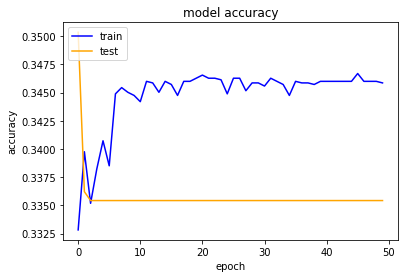

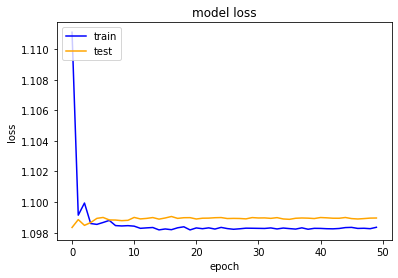

Epoch 1/50
113/113 [==============================] - 3s 25ms/step - loss: 1.1095 - auc: 0.5087 - val_loss: 1.1001 - val_auc: 0.5033
Epoch 2/50
113/113 [==============================] - 3s 22ms/step - loss: 1.0996 - auc: 0.5081 - val_loss: 1.0988 - val_auc: 0.4974
Epoch 3/50
113/113 [==============================] - 3s 22ms/step - loss: 1.0992 - auc: 0.5036 - val_loss: 1.0988 - val_auc: 0.5008
Epoch 4/50
113/113 [==============================] - 2s 22ms/step - loss: 1.0986 - auc: 0.5034 - val_loss: 1.0989 - val_auc: 0.5005
Epoch 5/50
113/113 [==============================] - 2s 22ms/step - loss: 1.0984 - auc: 0.5091 - val_loss: 1.0988 - val_auc: 0.5019
Epoch 6/50
113/113 [==============================] - 2s 22ms/step - loss: 1.0983 - auc: 0.5116 - val_loss: 1.0988 - val_auc: 0.4999
Epoch 7/50
113/113 [==============================] - 2s 22ms/step - loss: 1.0987 - auc: 0.5067 - val_loss: 1.0988 - val_auc: 0.5007
Epoch 8/50
113/113 [==============================] - 2s 22ms/step - 

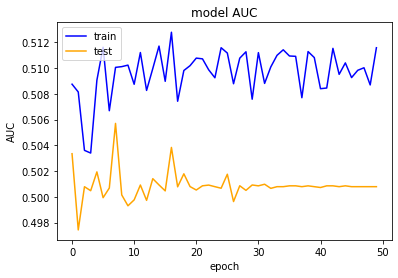

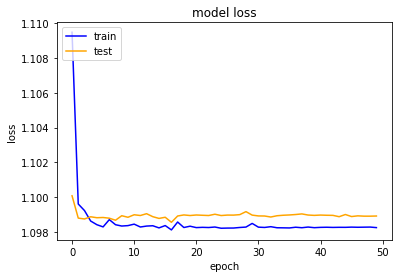

In [16]:
CNN_1D_acc = cnn_1(metric='accuracy')
model_cnn1_acc,history_cnn1_acc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=CNN_1D_acc,
                           model_name='CNN_1D_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

CNN_1D_auc = cnn_1(metric='AUC')
model_cnn1_auc,history_cnn1_auc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=CNN_1D_auc,
                           model_name='CNN_1D_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)

**LSTM**

Epoch 1/50
113/113 [==============================] - 126s 976ms/step - loss: 1.1204 - accuracy: 0.3339 - val_loss: 1.1073 - val_accuracy: 0.3307
Epoch 2/50
113/113 [==============================] - 109s 963ms/step - loss: 1.1053 - accuracy: 0.3385 - val_loss: 1.1017 - val_accuracy: 0.3370
Epoch 3/50
113/113 [==============================] - 108s 954ms/step - loss: 1.1043 - accuracy: 0.3319 - val_loss: 1.1003 - val_accuracy: 0.3331
Epoch 4/50
113/113 [==============================] - 107s 951ms/step - loss: 1.0999 - accuracy: 0.3357 - val_loss: 1.1040 - val_accuracy: 0.3307
Epoch 5/50
113/113 [==============================] - 107s 951ms/step - loss: 1.1003 - accuracy: 0.3370 - val_loss: 1.0986 - val_accuracy: 0.3268
Epoch 6/50
113/113 [==============================] - 108s 952ms/step - loss: 1.0986 - accuracy: 0.3441 - val_loss: 1.1000 - val_accuracy: 0.3551
Epoch 7/50
113/113 [==============================] - 108s 954ms/step - loss: 1.0994 - accuracy: 0.3445 - val_loss: 1.0994 -

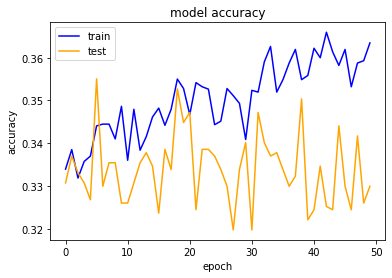

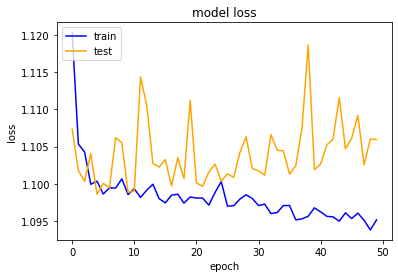

Epoch 1/50
113/113 [==============================] - 114s 976ms/step - loss: 1.1314 - auc: 0.5056 - val_loss: 1.1089 - val_auc: 0.5050
Epoch 2/50
113/113 [==============================] - 109s 968ms/step - loss: 1.1110 - auc: 0.5002 - val_loss: 1.1050 - val_auc: 0.5089
Epoch 3/50
113/113 [==============================] - 111s 979ms/step - loss: 1.0994 - auc: 0.5132 - val_loss: 1.0991 - val_auc: 0.5036
Epoch 4/50
113/113 [==============================] - 110s 978ms/step - loss: 1.0990 - auc: 0.5128 - val_loss: 1.1004 - val_auc: 0.5000
Epoch 5/50
113/113 [==============================] - 110s 973ms/step - loss: 1.0987 - auc: 0.5180 - val_loss: 1.0995 - val_auc: 0.5050
Epoch 6/50
113/113 [==============================] - 111s 979ms/step - loss: 1.0983 - auc: 0.5154 - val_loss: 1.0987 - val_auc: 0.5096
Epoch 7/50
113/113 [==============================] - 110s 976ms/step - loss: 1.0987 - auc: 0.5162 - val_loss: 1.0994 - val_auc: 0.5035
Epoch 8/50
113/113 [============================

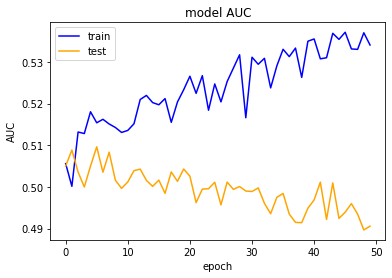

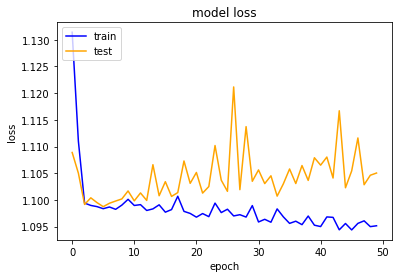

In [20]:
lstm_acc = lstm(metric='accuracy')
model_cnn2_acc,history_cnn2_acc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=lstm_acc,
                           model_name='lstm_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=50)

lstm_auc = lstm(metric='AUC')
model_cnn2_auc,history_cnn2_auc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=lstm_auc,
                           model_name='lstm_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=50)

**LSTM with Attention Mechanism**

Epoch 1/20
113/113 [==============================] - 134s 1s/step - loss: 1.1228 - accuracy: 0.3393 - val_loss: 1.1135 - val_accuracy: 0.3354
Epoch 2/20
113/113 [==============================] - 110s 970ms/step - loss: 1.1085 - accuracy: 0.3331 - val_loss: 1.1120 - val_accuracy: 0.3346
Epoch 3/20
113/113 [==============================] - 110s 976ms/step - loss: 1.1056 - accuracy: 0.3428 - val_loss: 1.1016 - val_accuracy: 0.3346
Epoch 4/20
113/113 [==============================] - 111s 985ms/step - loss: 1.0987 - accuracy: 0.3382 - val_loss: 1.0993 - val_accuracy: 0.3331
Epoch 5/20
113/113 [==============================] - 111s 985ms/step - loss: 1.0985 - accuracy: 0.3471 - val_loss: 1.1014 - val_accuracy: 0.3409
Epoch 6/20
113/113 [==============================] - 110s 978ms/step - loss: 1.0984 - accuracy: 0.3499 - val_loss: 1.1005 - val_accuracy: 0.3370
Epoch 7/20
113/113 [==============================] - 111s 983ms/step - loss: 1.0997 - accuracy: 0.3362 - val_loss: 1.1047 - va

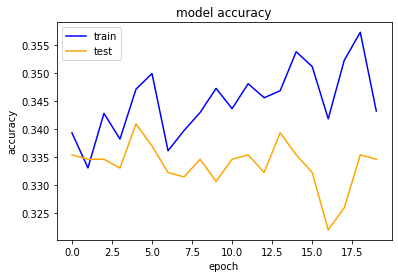

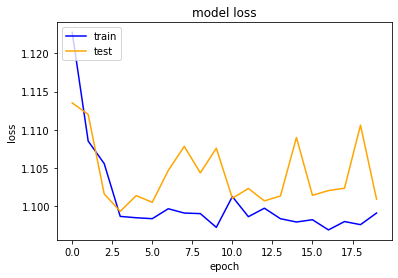

Epoch 1/20
113/113 [==============================] - 116s 998ms/step - loss: 1.1293 - auc: 0.5036 - val_loss: 1.1019 - val_auc: 0.4942
Epoch 2/20
113/113 [==============================] - 112s 988ms/step - loss: 1.1042 - auc: 0.5085 - val_loss: 1.1098 - val_auc: 0.5026
Epoch 3/20
113/113 [==============================] - 112s 990ms/step - loss: 1.1017 - auc: 0.5149 - val_loss: 1.1034 - val_auc: 0.5006
Epoch 4/20
113/113 [==============================] - 112s 991ms/step - loss: 1.1012 - auc: 0.5155 - val_loss: 1.1010 - val_auc: 0.4994
Epoch 5/20
113/113 [==============================] - 112s 988ms/step - loss: 1.0981 - auc: 0.5174 - val_loss: 1.1010 - val_auc: 0.4999
Epoch 6/20
113/113 [==============================] - 112s 989ms/step - loss: 1.0990 - auc: 0.5160 - val_loss: 1.1005 - val_auc: 0.4999
Epoch 7/20
113/113 [==============================] - 116s 1s/step - loss: 1.1001 - auc: 0.5098 - val_loss: 1.0996 - val_auc: 0.5044
Epoch 8/20
113/113 [==============================]

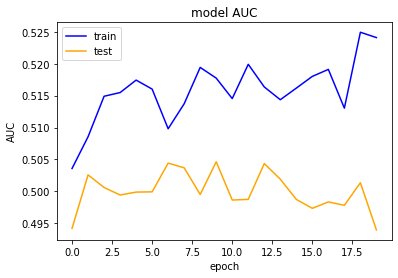

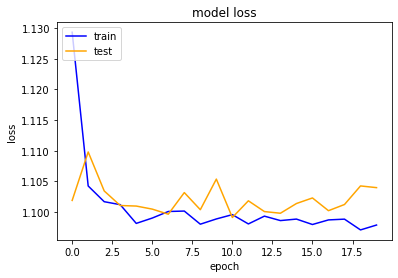

In [22]:
lstm_att_acc = lstm(metric='accuracy')
model_cnn2_acc,history_cnn2_acc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=lstm_att_acc,
                           model_name='lstm_att_acc',
                           metric='accuracy',
                           batch_size=64,
                           epochs=20)

lstm_att_auc = lstm(metric='AUC')
model_cnn2_auc,history_cnn2_auc = train_plot(x_train=x_train,
                           y_train=y_train,
                           model=lstm_att_auc,
                           model_name='lstm_att_auc',
                           metric='AUC',
                           batch_size=64,
                           epochs=20)